In [4]:
import tensorflow as tf
import os
import time
from matplotlib import pyplot as plt
from IPython import display
import cv2
# from google.colab.patches import cv2_imshow
import PIL
import numpy as np
# from google.colab.patches import cv2_imshow
import pandas as pd
from shutil import copyfile
from tqdm import tqdm

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Download the data for builing facades dataset.

You can use any other dataset as well. You need to make sure the input size, preproccessing etc is respectively updated according to your chosen dataset.

In [5]:
df = pd.read_csv('./Image-Colorization/data.csv')

train_imgs = set(df[df['split'] == 'train'].file_name.values)
valid_imgs = set(df[df['split'] == 'val'].file_name.values)
test_imgs  = set(df[df['split'] == 'test'].file_name.values)

dictionary = {'train': train_imgs, 'valid': valid_imgs, 'test': test_imgs}

src_path = '../input/flickr8kimagescaptions/flickr8k/images'
PATH = './'

In [7]:
BUFFER_SIZE = 400
BATCH_SIZE = 100
IMG_WIDTH = 256
IMG_HEIGHT = 256

### Loading the Image and preprocessing it

In [8]:
def load(img_file):
  '''
    load the image. Since we need only the target image and a 
    gray scale version of the same, we are going to load one 
    and create the other from it
  '''
  img = tf.io.read_file(img_file)
  img = tf.io.decode_jpeg(img)

#   w = tf.shape(img)[1]
#   w = w//2

#   real_image = img[:,:w,:]
  
  real_image = tf.cast(img,tf.float32)

  return real_image

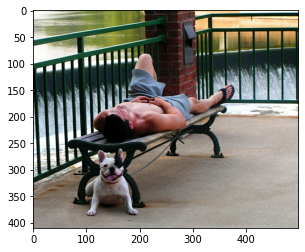

In [10]:
re = load(PATH+'/train/1003163366_44323f5815.jpg')
plt.figure()
plt.imshow(re/255.0)

In [11]:
def resize(image,height,width):
  '''
    Resizing the image
  '''
  resized_image = tf.image.resize(image,[height,width],method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  return resized_image

In [12]:
def random_crop(real_image):
  '''
    Applying Random crops for data augmentation purposes.
    we get a slightly larger image than the one we require.
    Thus we crop it randomly to our required size, in this case, 256x256
  '''
  cropped = tf.image.random_crop(
      real_image,size = [IMG_HEIGHT,IMG_WIDTH,3]
  )
  return cropped

In [13]:
def normalize(real_image,input_image):
  input_image = (input_image/127.5) - 1
  real_image = (real_image/127.5) - 1
  return real_image,input_image

In [14]:
@tf.function()
def random_jitter(real_image):
  '''
    This function is the one which will provide us with the input image
  '''
  real_image = resize(real_image,286,286)

  real_image = random_crop(real_image)

  if tf.random.uniform(())>0.5:
    real_image = tf.image.flip_left_right(real_image)
  input_image = tf.image.rgb_to_grayscale(real_image)
  return real_image,input_image

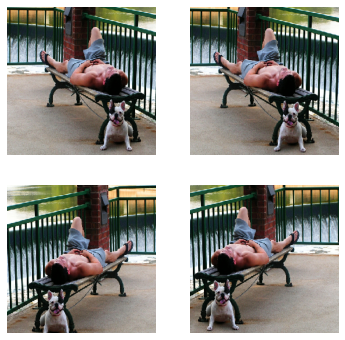

In [15]:
plt.figure(figsize=(6,6))
for i in range(4):
  rj_re,rj_inp = random_jitter(re)
  plt.subplot(2,2,i+1)
  plt.imshow(rj_re/255.0)
  plt.axis('off')
plt.show()

In [16]:
def load_image_train(image_file):
  re = load(image_file)
  re,inp = random_jitter(re)
  re,inp = normalize(re,inp)
  return inp,re

In [17]:
def load_image_test(image_file):
  '''
  We are not using random jitter here and thus creating
  a gray scale image after resizing.
  '''
  re = load(image_file)
  re = resize(re,IMG_HEIGHT,IMG_WIDTH)
  inp = tf.image.rgb_to_grayscale(re)
  re,inp = normalize(re,inp)
  return inp,re

## Input Pipeline

In [19]:
train_dataset = tf.data.Dataset.list_files(PATH+'/train/*.jpg')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls = tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [20]:
test_dataset = tf.data.Dataset.list_files(PATH+'/valid/*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

### Building the generator


*   U net arch
*   Encoder is Conv>BatchNorm>LeakyRelu
*   Decoder is TConv>BatchNorm>Dropout>Relu
*   Skip connections between encoder and decoder



In [21]:
OUTPUT_CHANNELS = 3

In [22]:
def downsample(filters,size,apply_batchnorm = True):
  '''
      A block in the generator for the first half
  '''
  initializer = tf.random_normal_initializer(0.0,0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters,
                             size,
                             strides=2,
                             padding='same',
                             kernel_initializer=initializer,
                             use_bias=False)
  )

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())
  
  result.add(tf.keras.layers.LeakyReLU())

  return result

In [23]:
down_model = downsample(512, 4)
down_result = down_model(tf.expand_dims(rj_inp, 0))
print (down_result.shape)

(1, 128, 128, 512)


In [24]:
def upsample(filters,size,apply_dropout = False):
  '''
      A block in the generator U Net in the second half of the Net
  '''
  initializer = tf.random_normal_initializer(0.0,0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2DTranspose(
          filters,
          size,
          strides=2,
          padding='same',
          kernel_initializer=initializer,
          use_bias = False
      )
  )
  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))
  
  result.add(tf.keras.layers.LeakyReLU())
  
  return result

In [25]:
up_model = upsample(512, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 512)


### Defining Generator
*   U Net with skip connections

In [26]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256,256,1])

  down_stack = [                       #Output Size
               downsample(64,4,False), #128
               downsample(128,4),      #64
               downsample(256,4),      #32
               downsample(512,4),      #16
               downsample(512,4),      #8
               downsample(512,4),      #4
               downsample(512,4),      #2
               downsample(512,4)       #1
  ]

  up_stack = [                         #Output&Channel Size
             upsample(512,4,True),     #2 1024-as we are concatenating for skip connections     
             upsample(512,4,True),     #4 1024
             upsample(512,4,True),     #8 1024
             upsample(512,4),          #16 1024
             upsample(256,4),          #32 512
             upsample(128,4),          #64 256
             upsample(64,4)            #128 128
  ]

  initializer = tf.random_normal_initializer(0.0,0.2)
  last = tf.keras.layers.Conv2DTranspose(
      OUTPUT_CHANNELS,
      4,
      2,
      padding = 'same',
      kernel_initializer = initializer,
      activation = 'tanh'
  )

  x = inputs

  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)
  
  skips = reversed(skips[:-1])

  for up,skip in zip(up_stack,skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x,skip])
  x = last(x)

  return tf.keras.Model(inputs=inputs,outputs=x)

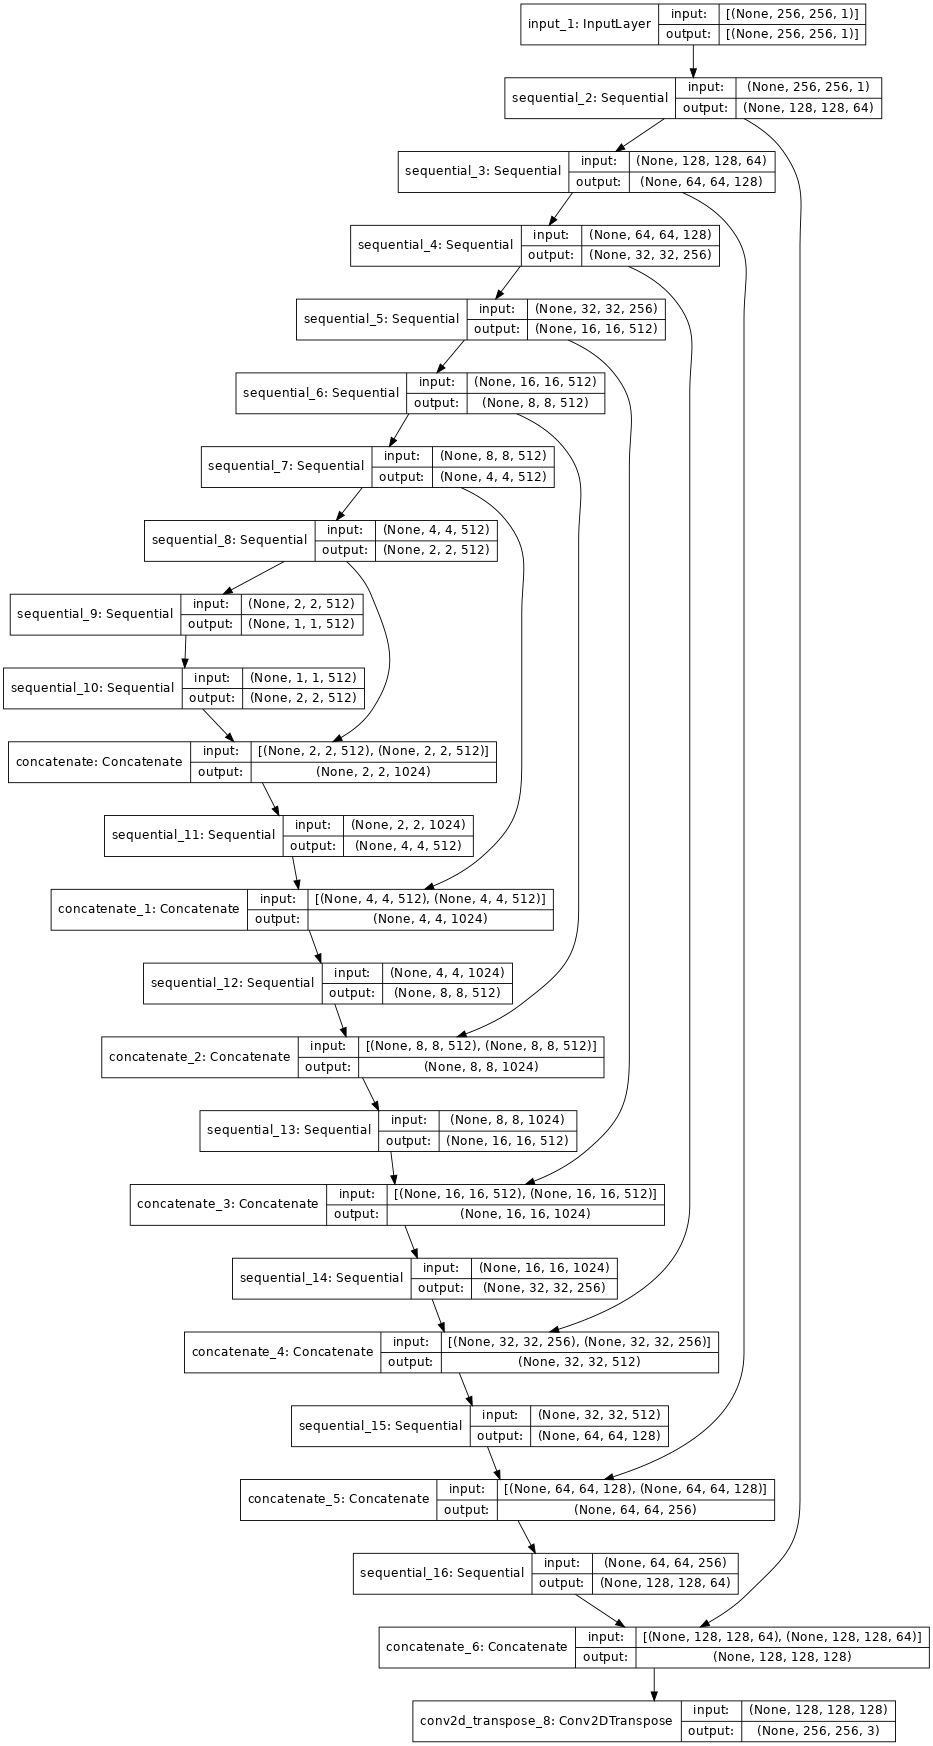

In [27]:
generator = Generator()
tf.keras.utils.plot_model(generator,show_shapes=True,dpi=64)

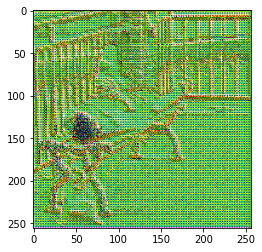

In [28]:
gen_output = generator(rj_inp[tf.newaxis,...],training = False)
plt.imshow(gen_output[0,...])


In [29]:
LAMBDA = 100

In [30]:
def generator_loss(disc_generated_output,gen_output,target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output),disc_generated_output)
  l1_loss = tf.reduce_mean(tf.abs(target-gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

### Discriminator


*   The Discriminator is a PatchGAN
*   Block is Conv>BatchNorm>LeakyRelu
*   Last shape bs,30,30,1 classifies 70x70 of the input image
*   Recieves two inputs
*   Input and Target( as real)
*   Input and generated Image which should be classified as fake
*   concat these input as tf.concat[inp,tar],axis=-1









In [31]:
def Discriminator():
  initializer = tf.random_normal_initializer(0,0.02)

  inp = tf.keras.layers.Input(shape=[256,256,1],name = "InputImage")
  tar = tf.keras.layers.Input(shape=[256,256,3],name='targetImage')

  x = tf.keras.layers.concatenate([inp,tar],axis =-1) # channels = 4

  down1 = downsample(64,4,False)(x) #128 64
  down2 = downsample(128,4)(down1)  #64 128
  down3 = downsample(256,4)(down2)  #32 256

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) #34 256
  conv = tf.keras.layers.Conv2D(512,4,1,kernel_initializer = initializer,use_bias = False)(zero_pad1) #31 512
  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) #33 512

  last = tf.keras.layers.Conv2D(1,4,1,kernel_initializer=initializer)(zero_pad2) #30 1

  return tf.keras.Model(inputs = [inp,tar],outputs = last)

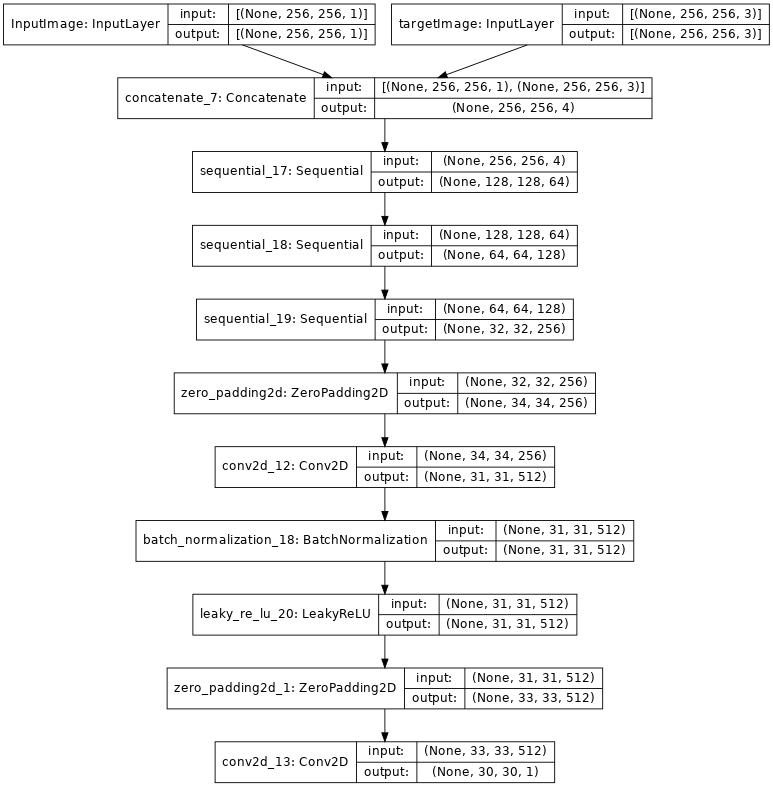

In [32]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator,show_shapes=True,dpi = 64)

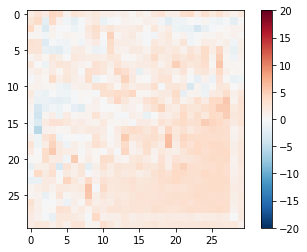

In [33]:
disc_output = discriminator([rj_inp[tf.newaxis,...],gen_output],training=False)
plt.imshow(disc_output[0,...,-1],vmin=-20,vmax=20,cmap ='RdBu_r')
plt.colorbar()

In [34]:
def discriminator_loss(disc_real_image,disc_gen_output):
  real_loss = loss_object(tf.ones_like(disc_real_image),disc_real_image)
  fake_loss = loss_object(tf.zeros_like(disc_gen_output),disc_gen_output)

  total_loss = real_loss + fake_loss
  return total_loss#,real_loss,fake_loss

## Optimizer and Checkpoint Saver

In [35]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4,beta_1 = 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4,beta_1=0.5)

In [36]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir,"ckpt")
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator
)

In [47]:
def generate_images(model,test_input,tar):
  prediction = model(test_input,training=True)
  plt.figure()
  plt.imshow(test_input[0,:,:,0],cmap='gray',interpolation='none')
  plt.figure(figsize=(9,9))
  #print(test_input[0].shape)
  #cv2_imshow(test_input[0])
  display_list = [tar[0],prediction[0]]

  title = ['Ground Truth','Predicted Image']
  for i in range(2):
    plt.subplot(1,2,i+1)
    plt.title(title[i])

    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

In [55]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    if i == 0:
        plt.imshow(display_list[i] * 0.5 + 0.5, cmap='gray')
    else:
        plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

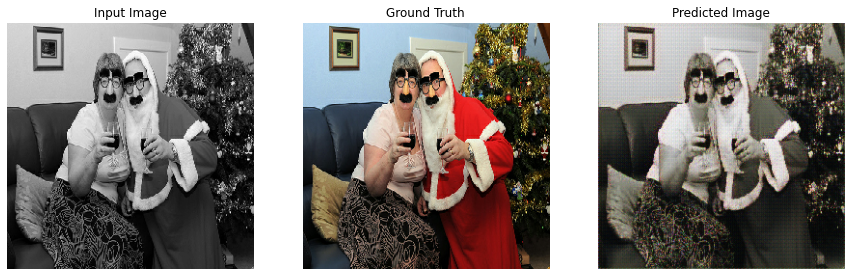

In [57]:
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

In [58]:
def generate_images_test(model,test_input,tar):
  prediction = model(test_input,training=True)
  #plt.figure()
  #plt.imshow(test_input[0,:,:,0],cmap='gray_r',interpolation='none')
  plt.figure(figsize=(9,9))
  #print(test_input[0].shape)
  #cv2_imshow(test_input[0])
  display_list = [None,tar[0],prediction[0]]

  title = ['Input Image','Ground Truth','Predicted Image']
  for i in range(3):
    plt.subplot(1,3,i+1)
    plt.title(title[i])
    if i==0:
      plt.imshow(test_input[0,:,:,0],cmap='gray')
    else:
      plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

### Training

In [59]:
EPOCHS = 150

In [60]:
import datetime
log_dir = 'logs/'

summary_writer = tf.summary.create_file_writer(log_dir+'fit/'+datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))

In [61]:
@tf.function 
def train_step(input_image,target,epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:
    gen_output = generator(input_image,training=True) #generated image
    
    dis_real_output = discriminator([input_image,target],training=True) #original image should be classified as real by discriminator
    dis_generated_output = discriminator([input_image,gen_output],training=True) #passing the generated image to the discriminator

    gen_total_loss,gen_gan_loss,gen_l1_loss = generator_loss(dis_generated_output,gen_output,target) #Generator loss
    dis_loss = discriminator_loss(dis_real_output,dis_generated_output) #discriminator loss

  generator_gradients = gen_tape.gradient(gen_total_loss,generator.trainable_variables) #calculated gradients using the losses for the varibles to be updated
  discriminator_gradients = dis_tape.gradient(dis_loss,discriminator.trainable_variables) #calculated gradients using the losses for the varibles to be updated

  #Once we have the gradients, we can updated respective trainable variables in our model for next iteration
  generator_optimizer.apply_gradients(zip(generator_gradients,generator.trainable_variables)) 
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss',gen_total_loss,step=epoch)
    tf.summary.scalar('gen_gan_loss',gen_gan_loss,step=epoch)
    tf.summary.scalar('gen_l1_loss',gen_l1_loss,step=epoch)
    tf.summary.scalar('dis_loss',dis_loss,step=epoch)


In [62]:
def fit(train_dataset,epochs,test_dataset):
  for epoch in range(epochs): #an epoch is a pass over the complete dataset
    start = time.time()

    display.clear_output(wait=True)

    for example_input,example_target in test_dataset.take(1): #printing an image at every epoch to visualize the updates in prediction 
      generate_images(generator,example_input,example_target)
    print("Epoch: ",epoch)

    for n,(input_image,target) in train_dataset.enumerate(): #running train_step iteratively
      print('.',end = '')
      if (n+1)%100 == 0:
        print()
      train_step(input_image,target,epoch)
    print()

    if (epoch+1)%20==0: #checkpoint after 20 epochs.
      checkpoint.save(file_prefix=checkpoint_prefix)
    print('Time Taken for epoch {} is {} sec\n'.format(epoch+1,time.time()-start))
  #checkpoint after finishing last epoch
  checkpoint.save(checkpoint_prefix)

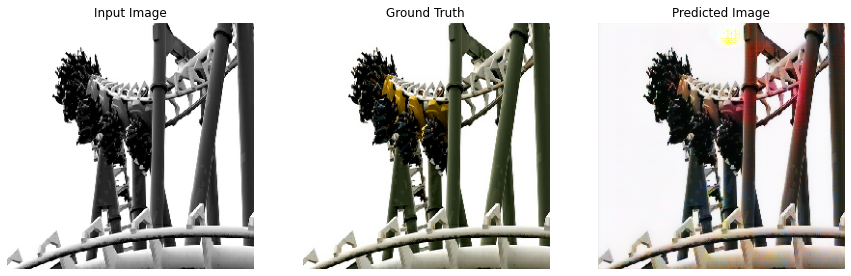

Epoch:  113
.................................................

KeyboardInterrupt: 

In [63]:
fit(train_dataset,EPOCHS,test_dataset)

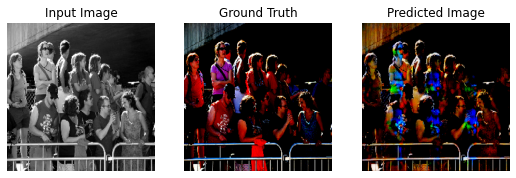

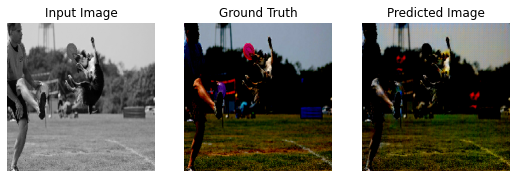

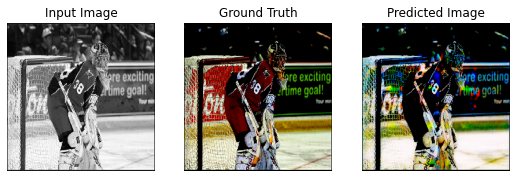

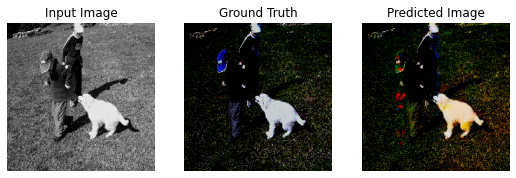

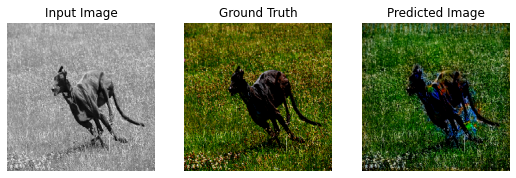

In [66]:
for inp,tar in test_dataset.take(5):
  generate_images_test(generator,inp,tar)